In [1]:
import gc
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import h3
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

# Load variables
from scripts import RAW_DATA_DIR, PROCESSED_DATA_DIR, TRAIN_FILE, TEST_FILE, MOBILITY_FILE

In [2]:
raw_train = pl.read_csv(RAW_DATA_DIR / TRAIN_FILE)
raw_test = pl.read_csv(RAW_DATA_DIR / TEST_FILE)
# Scan mobility data because is huge
raw_mobility_scan = pl.scan_parquet(RAW_DATA_DIR / MOBILITY_FILE)
print("Train shape: ", raw_train.shape)
print("Test shape: ", raw_test.shape)
print("Mobility shape: ", (raw_mobility_scan.select(pl.len()).collect()[0,0], len(raw_mobility_scan.collect_schema())))
print("Train dataset head:", raw_train.head())
print("Test dataset head:", raw_test.head())
print("Mobility dataset head:", raw_mobility_scan.head().collect())

Train shape:  (510, 2)
Test shape:  (511, 2)
Mobility shape:  (340411133, 4)
Train dataset head: shape: (5, 2)
┌─────────────────┬────────────────┐
│ hex_id          ┆ cost_of_living │
│ ---             ┆ ---            │
│ str             ┆ f64            │
╞═════════════════╪════════════════╡
│ 8866d338abfffff ┆ 0.372854       │
│ 8866d331b1fffff ┆ 0.424494       │
│ 888f2e3b4dfffff ┆ 0.414815       │
│ 888f2b9ae5fffff ┆ 0.687205       │
│ 8866d32363fffff ┆ 0.482482       │
└─────────────────┴────────────────┘
Test dataset head: shape: (5, 2)
┌─────────────────┬────────────────┐
│ hex_id          ┆ cost_of_living │
│ ---             ┆ ---            │
│ str             ┆ str            │
╞═════════════════╪════════════════╡
│ 888f2b983dfffff ┆ null           │
│ 888f2864b7fffff ┆ null           │
│ 8866d33813fffff ┆ null           │
│ 888f0d9acdfffff ┆ null           │
│ 8866d33a03fffff ┆ null           │
└─────────────────┴────────────────┘
Mobility dataset head: shape: (5, 4)
┌────

# Data types

In [3]:
print("Train dataset schema:")
print(raw_train.schema)

print("Test dataset schema:")
print(raw_test.schema)

print("Mobility dataset schema:")
print(raw_mobility_scan.collect_schema())

Train dataset schema:
Schema([('hex_id', String), ('cost_of_living', Float64)])
Test dataset schema:
Schema([('hex_id', String), ('cost_of_living', String)])
Mobility dataset schema:
Schema([('device_id', Int32), ('lat', Float64), ('lon', Float64), ('timestamp', Int64)])


In [4]:
sample_hex = raw_train.select(pl.col('hex_id'))[0,0]
resolution = h3.get_resolution(sample_hex)
print("Resolution of hex grid is: ", resolution)

Resolution of hex grid is:  8


In [5]:
del raw_test, raw_mobility_scan
gc.collect()

0

# Feature Description

In [6]:
mobility_scan = pl.scan_parquet(RAW_DATA_DIR / MOBILITY_FILE)

# Because this operation involves to use the entire dataset, I will do it column by column
for col in mobility_scan.collect_schema().names():
    print(mobility_scan.select(col).describe())
    print(mobility_scan.select(pl.col(col).approx_n_unique().alias(f"Number of uniques {col}")).collect(streaming=True))

shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ device_id     │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 3.40411133e8  │
│ null_count ┆ 0.0           │
│ mean       ┆ 1.0480e6      │
│ std        ┆ 603982.168434 │
│ min        ┆ 1.0           │
│ 25%        ┆ 525423.0      │
│ 50%        ┆ 1.048482e6    │
│ 75%        ┆ 1.564597e6    │
│ max        ┆ 2.104254e6    │
└────────────┴───────────────┘
shape: (1, 1)
┌─────────────────────────────┐
│ Number of uniques device_id │
│ ---                         │
│ u32                         │
╞═════════════════════════════╡
│ 2091079                     │
└─────────────────────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ lat          │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 3.40411133e8 │
│ null_count ┆ 0.0          │
│ mean       ┆ -1.317196    │
│ std        ┆ 1.121266     │

In [7]:
del raw_train
gc.collect()

0

# Mobility Analysis

In [8]:
processed_ms = pl.scan_parquet(PROCESSED_DATA_DIR, MOBILITY_FILE)

# Generate breakpoints for each month in 2021
min_timestamp = processed_ms.select('timestamp').min().collect()
max_timestamp = processed_ms.select('timestamp').max().collect()
breakpoints = pd.date_range(start=min_timestamp[0,0], end=max_timestamp[0,0], freq='ME').tolist()

# Transform breakpoints back to Unix
breakpoints = [int(bp.timestamp()) for bp in breakpoints]

In [9]:
# Create a new column with the bucketed timestamps
timestamp_buckets = processed_ms.select(
    pl.col("timestamp").cut(breakpoints).alias('timestamp_buckets')
)

# Collect the results to see the changes
timestamp_dist = timestamp_buckets.group_by('timestamp_buckets').len(name="count").collect(streaming=True)
timestamp_dist = timestamp_dist.to_pandas()

: 

/tmp/ipykernel_27111/4160097997.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels, rotation=45)


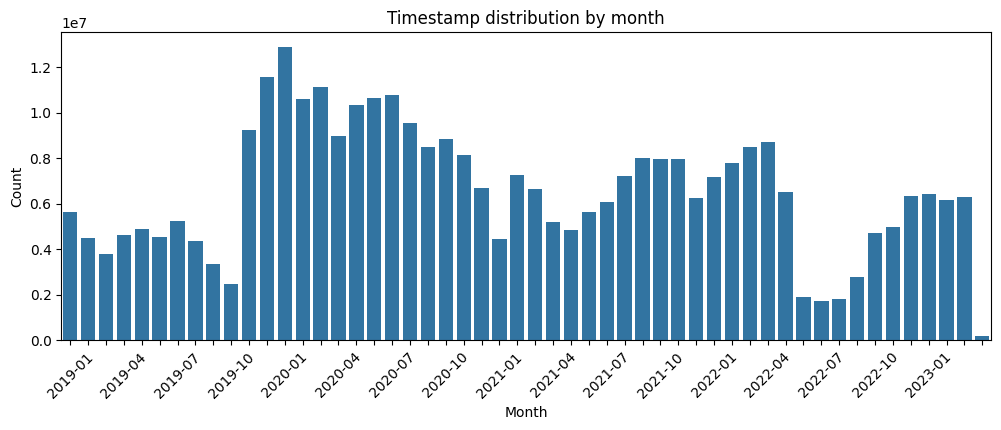

In [12]:
fig = plt.figure(figsize=(12, 4))
sns.barplot(data=timestamp_dist, x='timestamp_buckets', y='count')
plt.title("Timestamp distribution by month")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Count")
# Map x labels to year/month based on buckets
labels = ['' if i % 3 else pd.to_datetime(d, unit='s').strftime('%Y-%m') for i, d in enumerate(breakpoints)]
plt.gca().set_xticklabels(labels, rotation=45)
plt.show()

In [13]:
del processed_ms
gc.collect()

144